In [2]:
%load_ext autoreload
%autoreload 2

from preproccessing import loadStooqData
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import pyesg
import seaborn as sns
import matplotlib.pyplot as plt
from evaluation import show_scenarios_evaluation
import datetime
import pandas_datareader.data as web

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
data = loadStooqData('cpiypl.m','1973-12-31','y')

In [35]:
data.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 43 entries, 1982-12-31 to 2024-12-31
Series name: Zamkniecie
Non-Null Count  Dtype  
--------------  -----  
43 non-null     float64
dtypes: float64(1)
memory usage: 688.0 bytes


In [166]:
tickers = ['CPALTT01USQ657N','CPALTT01PLQ657N', 'CPALTT01DEQ657N']
start = datetime.datetime(1993, 1, 1)

end = datetime.datetime(2023, 12, 31)

df = web.DataReader(tickers, 'fred', start,end)

<AxesSubplot:xlabel='DATE'>

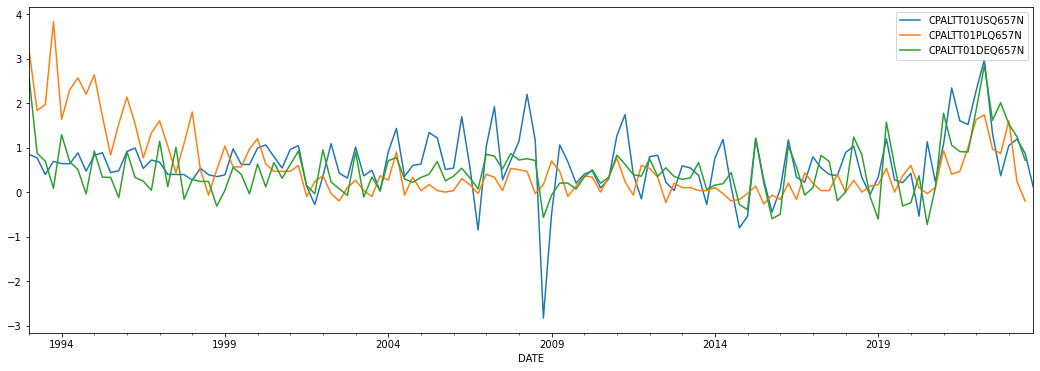

In [167]:
df.plot(figsize=(18,6))

In [168]:
df.corr()

,CPALTT01USQ657N,CPALTT01PLQ657N,CPALTT01DEQ657N
CPALTT01USQ657N,1.000000,0.235341,0.581785
CPALTT01PLQ657N,0.235341,1.000000,0.349382
CPALTT01DEQ657N,0.581785,0.349382,1.000000


In [5]:
def ornstein_uhlenbeck_params(series,period):
    lagged = series.shift(1).dropna()
    series = series.iloc[1:]
    lagged = sm.add_constant(lagged,prepend=False)
    model = sm.OLS(series['Zamkniecie'],lagged[['Zamkniecie','const']])
    res = model.fit()
    b = res.params['Zamkniecie']
    a = res.params['const']
    k = (1 -b)/period
    u = a/(1-b)
    sig = np.sqrt(res.scale)
    
    return (u,sig,k) 

""" def ornstein_uhlenbeck_params(series,period):
    lagged = series.shift(1).dropna()
    series = series.iloc[1:]
    lagged = sm.add_constant(lagged,prepend=False)
    model = sm.OLS(series,lagged[['CPALTT01USQ657N','const']])
    res = model.fit()
    b = res.params['CPALTT01USQ657N']
    a = res.params['const']
    k = (1 -b)/period
    u = a/(1-b)
    sig = np.sqrt(res.scale)
    
    return (u,sig,k) """


" def ornstein_uhlenbeck_params(series,period):\n    lagged = series.shift(1).dropna()\n    series = series.iloc[1:]\n    lagged = sm.add_constant(lagged,prepend=False)\n    model = sm.OLS(series,lagged[['CPALTT01USQ657N','const']])\n    res = model.fit()\n    b = res.params['CPALTT01USQ657N']\n    a = res.params['const']\n    k = (1 -b)/period\n    u = a/(1-b)\n    sig = np.sqrt(res.scale)\n    \n    return (u,sig,k) "

,Zamkniecie
count,19.000000
mean,0.024072
std,0.021003
min,-0.010050
2%,-0.008237
5%,-0.005516
10%,0.004578
25%,0.009454
50%,0.023717
75%,0.033918


<AxesSubplot:xlabel='Data', ylabel='Zamkniecie'>

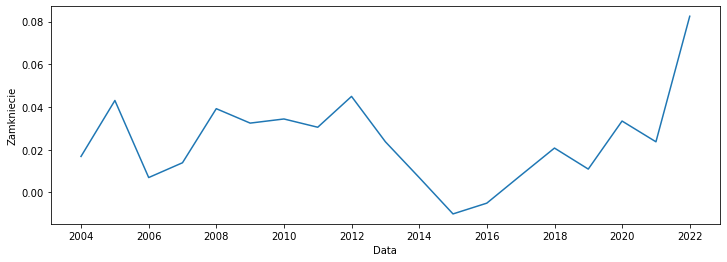

In [38]:
cpi = data['2003-01-01':'2021-12-31'] /100
cpi = np.log(cpi+1)
cpi = cpi.reset_index()
cpi.set_index(cpi['Data'])
cpi = cpi.dropna()
display(cpi.describe(percentiles=[0.02,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.98]))
fig, ax = plt.subplots(figsize=(12,4))
sns.lineplot(data=cpi,x='Data',y='Zamkniecie', ax=ax)

In [7]:
cpi.iloc[-1]

Data          2021-12-31 00:00:00
Zamkniecie               0.082501
Name: 18, dtype: object

<AxesSubplot:ylabel='Count'>

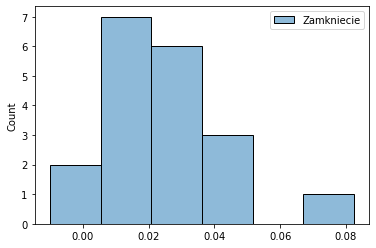

In [8]:
sns.histplot(data=cpi)

In [39]:
u,sig,k = ornstein_uhlenbeck_params(cpi,1)
print(u)
print(sig)
print(k)

0.027562135620284346
0.02087654946576434
0.5413491319817536


In [45]:
#moje param mu - 2,5%, sig, 1,5%, k- 0.k
param_mu = 0.025 
param_sig = 0.025
param_k = 0.54
simulator = pyesg.OrnsteinUhlenbeckProcess(mu=param_mu,sigma=param_sig,theta=param_k)
length = 360
h= 1/12
scenarios = simulator.scenarios(0.039,h,1000,length)
scenarios = pd.DataFrame(scenarios)

#show_scenarios_evaluation(scenarios,cpi['Zamkniecie'])

Sample paths


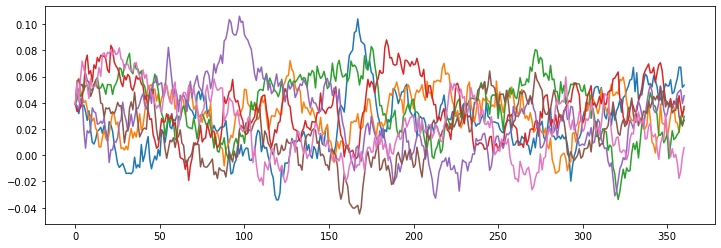

None
Fanchart


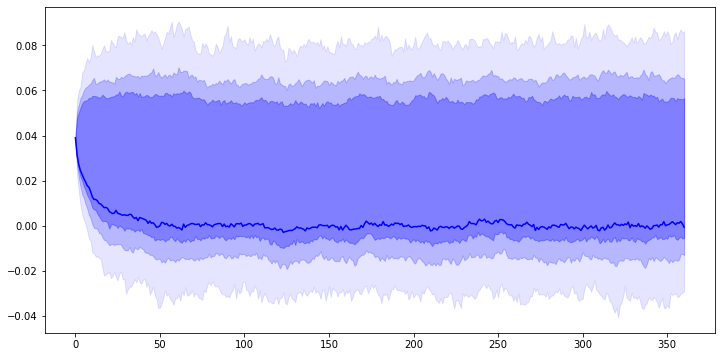

None
Percentaile summary


,12,36,60,120,240,360
1,-0.013745,-0.025223,-0.032239,-0.034898,-0.027233,-0.029099
5,-0.001149,-0.010241,-0.014940,-0.017208,-0.014005,-0.013056
10,0.006872,-0.001952,-0.005443,-0.008506,-0.003477,-0.005333
15,0.011646,0.003626,-0.001085,-0.001974,0.002140,-0.000704
25,0.018814,0.012179,0.010330,0.008044,0.011093,0.008673
50,0.032990,0.028083,0.025984,0.024878,0.025749,0.025963
75,0.046654,0.044031,0.043258,0.040533,0.042946,0.042131
85,0.052983,0.051983,0.052429,0.048962,0.051224,0.050502
90,0.057437,0.058908,0.058794,0.053806,0.057226,0.056559
95,0.062824,0.066206,0.067172,0.065906,0.065980,0.065187


Scenarios summary stats


,Annualised Mean,Annualised Sigma,Skew,Kurtosis,Sharp_ratio,Max drowdawn
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.025826,0.022394,-0.008983,-0.210617,12.859232,-0.292331
std,0.008034,0.003797,0.355436,0.502315,5.000763,0.216370
min,-0.002332,0.014150,-1.188248,-1.149317,-3.067301,-0.978122
25%,0.020565,0.019623,-0.244246,-0.567285,9.380578,-0.430012
50%,0.025743,0.022032,-0.008935,-0.288443,12.567855,-0.251662
75%,0.031348,0.024808,0.241417,0.037013,16.041544,-0.115879
max,0.053137,0.036966,1.497979,2.938685,31.271566,0.000000


In [46]:
from evaluation import describe_scenarios_vertically, fanchart, percentile_summary, sample_paths

print(sample_paths(scenarios))

print(fanchart(scenarios))
    
display(percentile_summary(scenarios, data_freq=12, years = np.array([1,3,5,10,20,30])))

cum_scenarios = scenarios.mean(axis=1)
display(describe_scenarios_vertically(scenarios.T,'y'))

In [159]:
0.011596 * 12

0.139152

In [181]:
model = tsa.MarkovAutoregression(cpi['CPALTT01USQ657N'],3,order=1,switching_variance=True,switching_ar=True)
res = model.fit() 
res.summary()

c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:          CPALTT01USQ657N   No. Observations:                  123
Model:             MarkovAutoregression   Log Likelihood                 476.287
Date:                  Wed, 14 Feb 2024   AIC                           -922.574
Time:                          23:08:00   BIC                           -880.391
Sample:                               0   HQIC                          -905.439
                                  - 123                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039   4.02e-05     96.566      0.000       0.004       0.004
sigma2      9.027e-09        nan        nan        nan         nan         nan
ar.L1         -0.0404      0.009     -4.367      0.000      -0.059      -0.022
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0062      0.001     10.772      0.000       0.005       0.007
sigma2      1.413e-05   3.18e-06      4.451      0.000    7.91e-06    2.04e-05
ar.L1          0.2130      0.102      2.085      0.037       0.013       0.413
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0068      0.003      1.986      0.047    8.96e-05       0.013
sigma2         0.0001   3.15e-05      3.492      0.000    4.82e-05       0.000
ar.L1          0.3365      0.188      1.794      0.073      -0.031       0.704
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.1997      0.114      1.752      0.080      -0.024       0.423
p[1->0]        0.1170      0.059      1.988      0.047       0.002       0.232
p[2->0]     7.158e-05      0.099      0.001      0.999      -0.195       0.195
p[0->1]        0.6553      0.200      3.281      0.001       0.264       1.047
p[1->1]        0.8518      0.063     13.464      0.000       0.728       0.976
p[2->1]        0.1209      0.114      1.061      0.289      -0.103       0.344
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [176]:
0.0071*4

0.0284

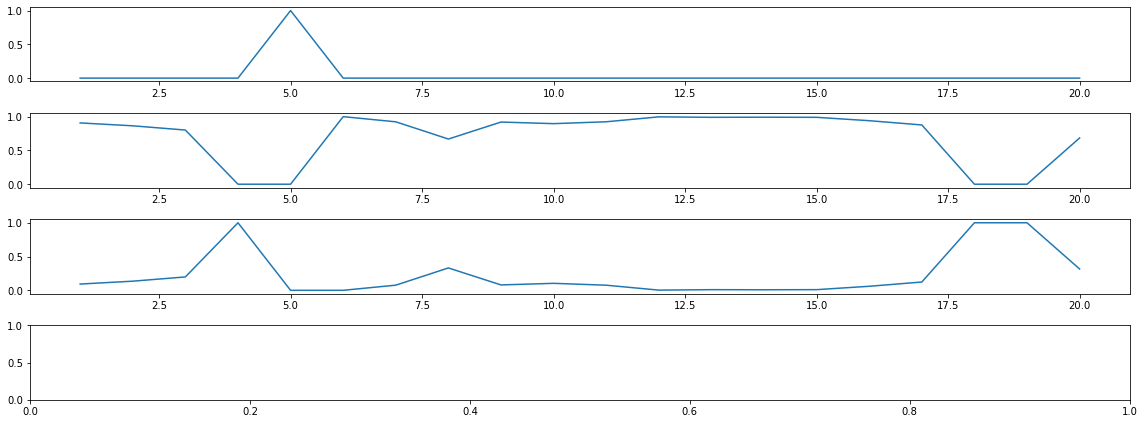

In [69]:
fig, axes = plt.subplots(4, figsize=(16, 6))
ax = axes[0]
ax.plot(res.filtered_marginal_probabilities[0])

ax = axes[1]
ax.plot(res.smoothed_marginal_probabilities[1])

ax = axes[2]
ax.plot(res.smoothed_marginal_probabilities[2])

ax = axes[3]
#ax.plot(res.smoothed_marginal_probabilities[3]) 

fig.tight_layout()

In [73]:
np.round(res.params,4)

p[0->0]      0.0055
p[1->0]      0.0026
p[2->0]      0.2133
p[0->1]      0.9945
p[1->1]      0.8093
p[2->1]      0.2357
const[0]     0.0005
const[1]     0.0218
const[2]     0.0428
sigma2[0]    0.0000
sigma2[1]    0.0000
sigma2[2]    0.0005
ar.L1[0]    -0.1255
ar.L1[1]     0.5066
ar.L1[2]     0.4074
dtype: float64

In [74]:
#np.savetxt('edo_25.09.23_m.csv', np.round(edo,4),delimiter=', ', comments='testowa')

In [76]:
def ou_params_transform(const, ar,dt):
    k=(1-ar)/dt
    u = const/(1-ar)
    return k,u

def ou_rs_params(params,k,dt):
    result = np.zeros((k,3))
    for r in range(k):
        p = ou_params_transform(params[f"const[{r}]"],params[f'ar.L1[{r}]'],dt)
        #p = ou_params_transform(params[f"const[{r}]"],params[f'ar.L1'],dt)
        result[r,0] = p[0]
        result[r,1] = p[1] 
        result[r,2] = np.sqrt(params[f'sigma2[{r}]']) *np.sqrt(dt)
    return result

print(np.round(ou_rs_params(res.params,3,1),2))

[[1.13 0.   0.  ]
 [0.49 0.04 0.01]
 [0.59 0.07 0.02]]


In [278]:
pl_cpi = loadStooqData('cpiypl.m','2003-12-31','y')
us_cpi = loadStooqData('cpiyus.m','1973-12-31','y')
pl_cpi.corr(us_cpi)

0.7966189478408742

#TODO
- single regime 2003-2021, albo 2020
- backfill


In [193]:
from scipy.stats import norm, t

print(norm.cdf(0.03, 0,0.01))
print(t.cdf(0.03, 2, 0,0.01))

0.9986501019683699
0.9522670168666454


In [50]:
set(range(1,4))

{1, 2, 3}